In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
import urllib.request
import utils

In [2]:
def load_problem_instance(url):
	qap_instance_file = urllib.request.urlopen(url)

	line = qap_instance_file.readline()
	n = int(line.decode()[:-1].split()[0])
	print('Problem size: %d' % n)

	def read(n):
		M = np.empty((n, n))
		for i in range(n):
			values = []
			while len(values) < n:
				line = qap_instance_file.readline()
				values.extend(list(map(int, line.decode()[:-1].split())))
			M[i, :] = values
		return M

	A = read(n)
	print('Flow matrix:\n', A.shape)

	B = read(n)
	print('Distance matrix:\n', B.shape)

	def f(p):
		s = 0.0
		for i in range(n):
			s += (A[i, :] * B[p[i], p]).sum()
		return s
	return n, f

In [3]:
QAPLIB_URL = 'https://www.opt.math.tugraz.at/qaplib/data.d/'
n, qap = load_problem_instance(QAPLIB_URL + 'nug20.dat')

Problem size: 20
Flow matrix:
 (20, 20)
Distance matrix:
 (20, 20)


## Local search implementation

In [4]:
from itertools import permutations, combinations

In [5]:
def perms(p):
	return np.fromiter(permutations(p), dtype=np.dtype((int, len(p))))

def permute_indices(p, indices):
	for perm in perms(p[indices]):
		(x := p.copy())[indices] = perm
		yield x

In [6]:
def local_search(p, f, k = 2):
	if 0 <= k <= 1:
		return p

	indices = np.arange(len(p))
	return min(
		(min(permute_indices(np.array(p), np.array(comb)), key=f)
		for comb in combinations(indices, k)),
		key=f
	)

In [7]:
def local_search_greedy(p, f, k = 2):
	q, v = p, f(p)
	while f(q := local_search(q, f, k)) < v:
		v = f(q)
	return q

In [8]:
x = [5,1,4,2,3]
of = lambda p: np.sum(p * np.arange(len(p)))

print(local_search(x, of, 5))
assert np.array_equiv(local_search(x, of, 5), local_search_greedy(x, of, 2))

[5 4 3 2 1]


## Compare k

In [9]:
from SGA import Mutation, Crossover, simple_genetic_algorithm

def wrap(f, *arg):
	def inner(x):
		if np.random.random() < 0.1:
			return f(x, *arg)
		return Mutation.reverse_sequence_mutation(x)
	return inner

def sga(mutator):
	return [score for _, score in simple_genetic_algorithm(n, Crossover.PMX, mutator, qap, population=10)]

In [10]:
N = 10
benchmarks = {}

for k in (0,2,3,4):
	benchmarks[k] = sum(np.array(sga(wrap(local_search, qap, k))) for _ in range(N)) / N

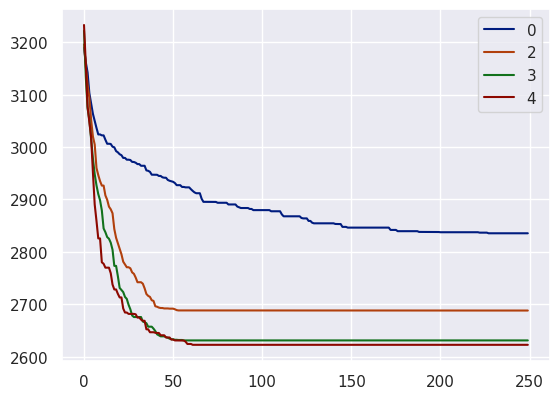

<Figure size 640x480 with 0 Axes>

In [11]:
utils.quickplot(*list(benchmarks.values()), legend=list(benchmarks.keys()))

In [12]:
benchmarks = {
	"pure": sga(Mutation.reverse_sequence_mutation),
	"greedy search (k=2)": sga(wrap(local_search_greedy, qap))	
}

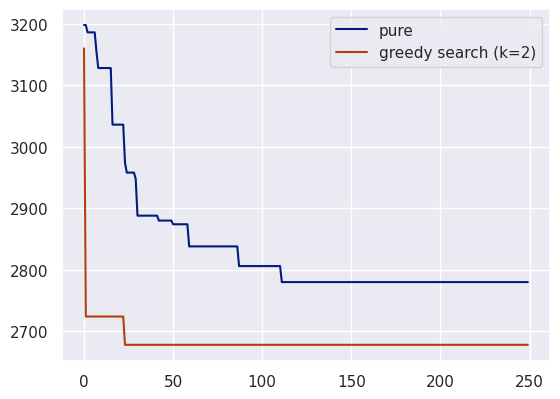

<Figure size 640x480 with 0 Axes>

In [13]:
utils.quickplot(*list(benchmarks.values()), legend=list(benchmarks.keys()))